# Talking Motion Signature of Individuals
*Ivan Samarskyi, 2024*

In [26]:
import numpy as np
import pandas as pd
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [27]:
CORRELATIONS = ""
EXAMPLE_EXTRACTED = ""
if "kaggle" in os.getcwd():
    print(f"Running in kaggle...")
    CORRELATIONS = "/kaggle/input/correlations/correlations.csv"
else:
    print(f"Running locally...")
    CORRELATIONS = os.path.join("data", "correlations.csv")
    EXAMPLE_EXTRACTED = "data/extracted/clip_c0_features.csv"


cors = pd.read_csv(CORRELATIONS, index_col="clip_name")
print("The cor dataset was loaded successfully")

extracted_ex = pd.read_csv(EXAMPLE_EXTRACTED)
print("Example extracted features loaded successfully.")

Running locally...
The cor dataset was loaded successfully
Example extracted features loaded successfully.


## Data Exploration and Analysis

### General information:
The dataset used in this particular implementstion encompasses:
1. **... minutes** of pristine videos of ... individuals, taken from VoxCeleb_v2

### Temporal information:
- Most of the videos are 4-10 seconds of length.

### Video preprocessing:
- Videos were not preprocessed at all:
    - Some of the frames do not contain a person at all
    - Several frames may also contain transitions
- Videos are also separated into small clips Xs each overlapping by Y seconds clips

### Data extraction
- Normalised body landmarks, AUs and head rotations are then extracted from the clips
- To represent some complex movements, temporal correlation are extracted for all detected features.

### Dataset explanation
- The dataset's index conveniently denotes from which video and clip the data was extracted.

**Example:**
`id01026_xGwXIrtXn7w_00098.mp4`:
   - `id01026` id of an individual
   - `xGwXIrtXn7w` video id
   - `00098` person's occurence

   *in case it is a clip of this video, one part is added: `id01026_xGwXIrtXn7w_00098_c0.mp4`*
   - `c0` where 0 is an id of a clip

Columns of the dataset are correlations bewtween the extracted features. the template is `feature1*feature2`. Total number of correlations: **...**
**Example:**
`leftShoulder_X*rightShoulder_X`

- Total number of clips extracted is **...**

In [34]:
display(extracted_ex.info())
display(extracted_ex.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pitch               300 non-null    float64
 1   Roll                300 non-null    float64
 2   Yaw                 300 non-null    float64
 3   Eye Aspect Ratio    300 non-null    float64
 4   Mouth Aspect Ratio  300 non-null    float64
 5   Occ_au_1            300 non-null    float64
 6   Occ_au_2            300 non-null    float64
 7   Occ_au_4            300 non-null    float64
 8   Occ_au_7            300 non-null    float64
 9   Occ_au_15           300 non-null    float64
 10  Occ_au_23           300 non-null    float64
 11  Occ_au_24           300 non-null    float64
 12  Occ_au_6            300 non-null    float64
 13  Occ_au_10           300 non-null    float64
 14  Occ_au_12           300 non-null    float64
 15  Occ_au_14           300 non-null    float64
 16  Occ_au_1

None

Pitch                 300
Roll                  300
Yaw                   300
Eye Aspect Ratio      300
Mouth Aspect Ratio    300
Occ_au_1              300
Occ_au_2              300
Occ_au_4              300
Occ_au_7              299
Occ_au_15             300
Occ_au_23             300
Occ_au_24             300
Occ_au_6              300
Occ_au_10             300
Occ_au_12             300
Occ_au_14             300
Occ_au_17             300
leftShoulder_X        300
leftShoulder_Y        300
rightShoulder_X       300
rightShoulder_Y       300
leftElbow_X           300
leftElbow_Y           300
rightElbow_X          300
rightElbow_Y          300
leftWrist_X           300
leftWrist_Y           300
rightWrist_X          300
rightWrist_Y          300
leftEye_X             300
leftEye_Y             300
dtype: int64

Observe that all of **31** features are **numeric** in their nature. 

In attempt to verify the quality of the extraction, visualisation of the extracted data of a random clip is presented:

In [29]:
#TODO: Visualize one video with all action units and body landmarks on it

The `NaN` values could be present in the dataset in rare cases. Due to the fact that correlations are being calculated on the extracted features of each clip, a correlation can be `NaN` only when one of the values it is calculated in is `NaN`. This, iself, can happen when extractor cannot detect a face or a person on the frame. To make the consequences of the fact that a person is not present on some of the frames, if less then **50%** of frames have `NaN`s in them, they are replaced with `mean`. Otherwise, the correlation will be `NaN`.

On the other hand, from a more high-level perspective, when an extractor fails to find a person on the frame, or faces other obstacles in more than **50%** of frames and these errors trickle to over **10%** of the **correlations**, this row is excluded.

In [35]:
DATAPOINTS_CNT = len(cors)
FEATURES_CNT = len(cors.columns)
CELLS_CNT = DATAPOINTS_CNT * FEATURES_CNT
NAN_THRESHOLD_P = 0.01
NAN_THRESHOLD_V = NAN_THRESHOLD_P * FEATURES_CNT

# cors.isnull() Return a bitmap for all cells (True/False)
nan_total_ratio = cors.isnull().sum().sum() / CELLS_CNT
print(f"Ratio of NaN values to in the dataset: {nan_total_ratio:.2%}")

nan_row_ratio = cors.isnull().any(axis=1).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have NaN values in them: {nan_row_ratio:.2%}")

nan_row_ratio = (cors.isnull().sum(axis=1) > NAN_THRESHOLD_V).sum() / DATAPOINTS_CNT
print(f"Ratio of datapoints which have more than {NAN_THRESHOLD_P:.2%} NaN values in them: {nan_row_ratio:.2%}, \
[actual NaN features cnt thresh.: {NAN_THRESHOLD_V:.0f}]")

nan_col_ratio = cors.isnull().any().sum() / FEATURES_CNT
print(f"Ratio of features which have NaN values in them: {nan_col_ratio:.2%}")

cors = cors[cors.isna().sum(axis=1) <= NAN_THRESHOLD_V]
print(f"Datapoints left: {len(cors)}, number of NaNs in the dataset: {cors.isnull().sum().sum()}")

Ratio of NaN values to in the dataset: 0.00%
Ratio of datapoints which have NaN values in them: 0.00%
Ratio of datapoints which have more than 1.00% NaN values in them: 0.00%, [actual NaN features cnt thresh.: 5]
Ratio of features which have NaN values in them: 0.00%
Datapoints left: 1, number of NaNs in the dataset: 0


In [ ]:
# Derive target variable

In [ ]:
# Subset of features
# Clip length
# Influence of compression

To further control how certain features describe the identity lets split the dataset into 3:
- All feature combined
- Only facial
- Only body

In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
for column in cors.columns:
    cors[column] = imputer.fit_transform(cors[[column]])

In [50]:
cors_full = cors

body_columns = [col for col in cors.columns if col.endswith('_X') or col.endswith('_Y')]
cors_body = cors[body_columns]

face_columns = [col for col in cors.columns if not (col.endswith('_X') or col.endswith('_Y'))]
cors_face = cors[face_columns]

Add the `y` pd.Series which would represent the target variable

In [51]:
y = pd.Series(cors.index.str.contains("pristine"))

Although all of the features are Pearson correlations, still, they can be standardized to avoid potential probllems because distribution of each feature is unknown at this point. (Irrational to check each one)

In [52]:
scaler = StandardScaler()

X_full = scaler.fit_transform(cors_full)
X_body = scaler.fit_transform(cors_body)
X_face = scaler.fit_transform(cors_face)

#### Model training

In [55]:
def base_model(X: np.ndarray):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'poly']
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best accuracy:", grid_search.best_score_)

    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train, y_train)

    y_pred = best_svm.predict(X_test)
    
    # Visualizations
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Pristine', 'Pristine'], yticklabels=['Not Pristine', 'Pristine'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, best_svm.decision_function(X_test))
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

Train the first full model to have a baseline

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9665796344647519


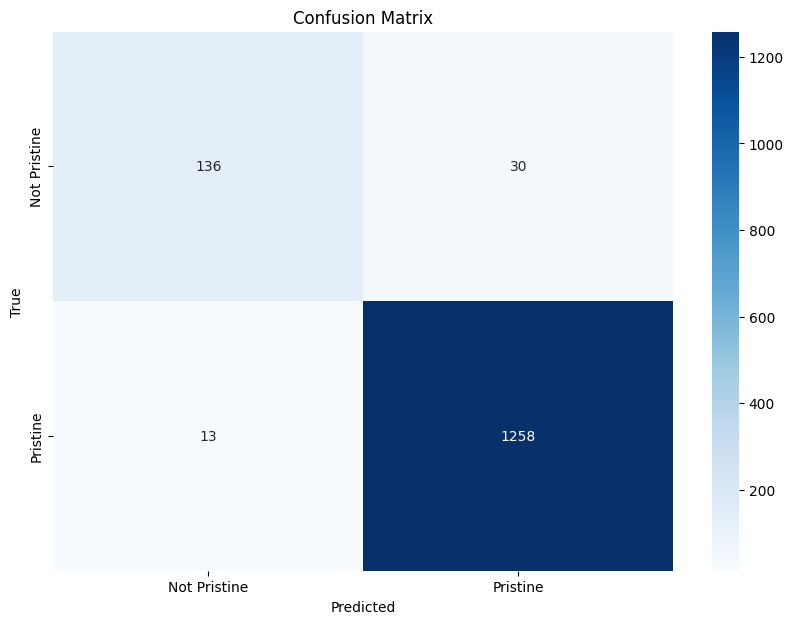

              precision    recall  f1-score   support

       False       0.91      0.82      0.86       166
        True       0.98      0.99      0.98      1271

    accuracy                           0.97      1437
   macro avg       0.94      0.90      0.92      1437
weighted avg       0.97      0.97      0.97      1437



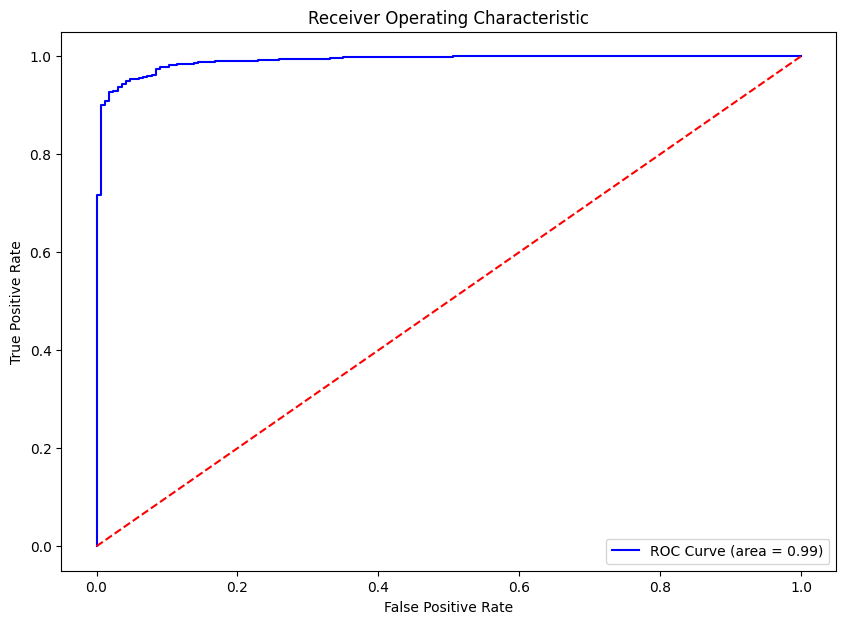

In [56]:
base_model(X_full)

Now the body-only

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9096605744125327


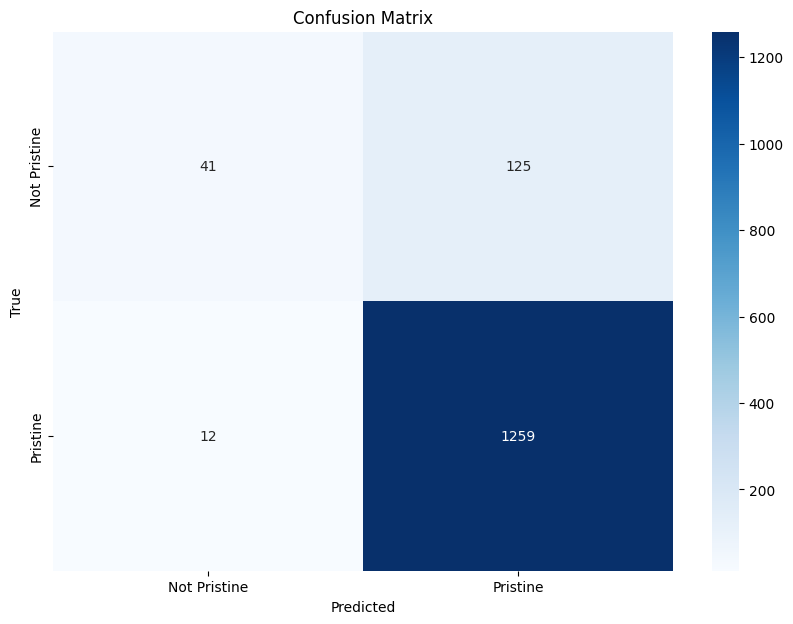

              precision    recall  f1-score   support

       False       0.77      0.25      0.37       166
        True       0.91      0.99      0.95      1271

    accuracy                           0.90      1437
   macro avg       0.84      0.62      0.66      1437
weighted avg       0.89      0.90      0.88      1437



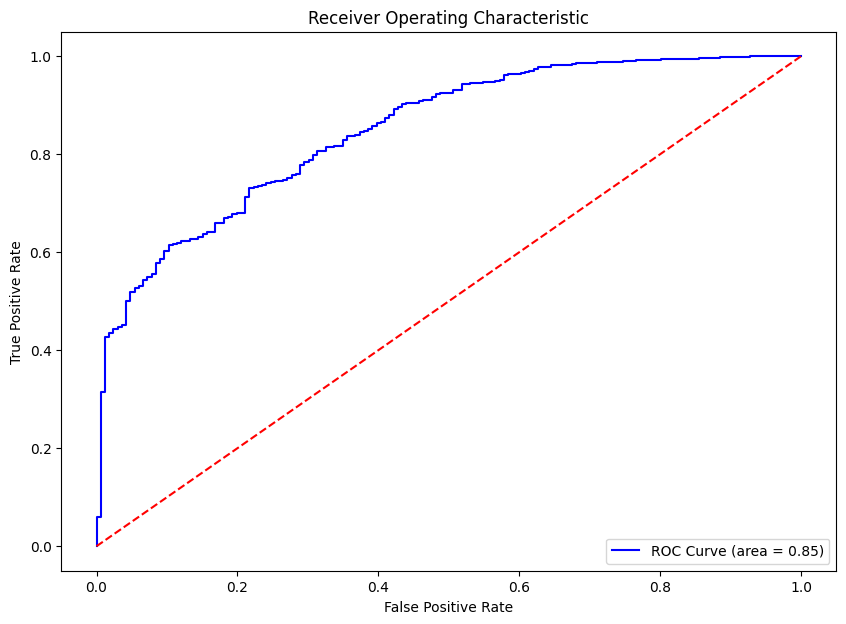

In [57]:
base_model(X_body)

And the face-only

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.9658833768494344


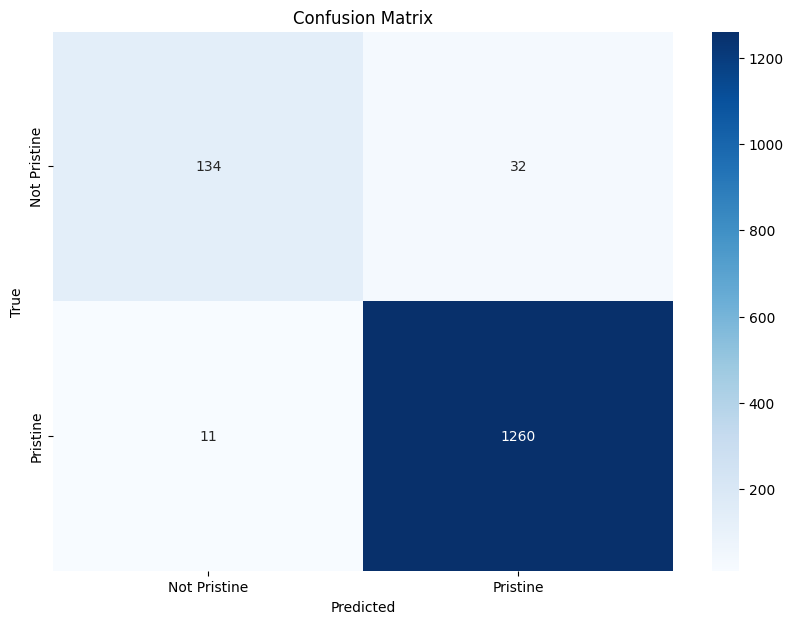

              precision    recall  f1-score   support

       False       0.92      0.81      0.86       166
        True       0.98      0.99      0.98      1271

    accuracy                           0.97      1437
   macro avg       0.95      0.90      0.92      1437
weighted avg       0.97      0.97      0.97      1437



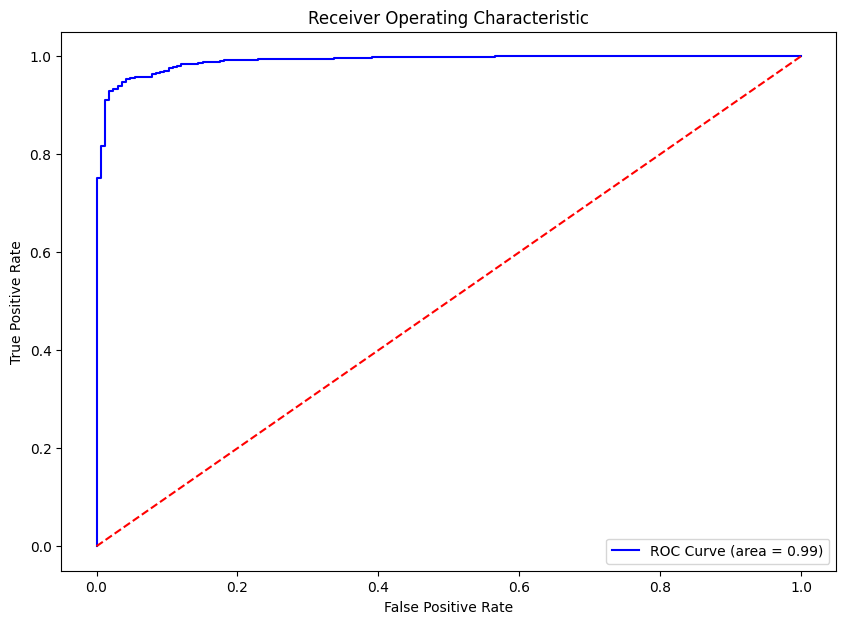

In [58]:
base_model(X_face)

Run the full model for 10 times to get its average performance

In [59]:
# f1 = []

# for i in range(0,10):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
    
#     best_svm = grid_search.best_estimator_
#     best_svm.fit(X_train, y_train)
    
#     f1.append(best_svm.predict(X_test))
    
# print("Average f1 through 10 random splits: ", sum(f1)/len(f1))

#### Simple visualization

/home/samarrik/projects/protecting_zelenskyi/venv_zel/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


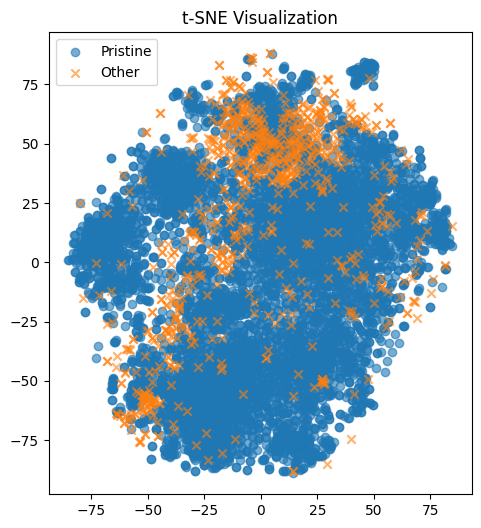

In [60]:
# Adjust PCA components
pca = PCA(n_components=50)  # Increased to 50 components
X_pca = pca.fit_transform(X_full)

tsne = TSNE(
    n_components=2,
    n_iter=3000,          # Increased iterations
    perplexity=40,        # Adjusted perplexity
    learning_rate=200,    # Adjusted learning rate
    random_state=42
)
X_tsne = tsne.fit_transform(X_pca)

# Plotting the t-SNE results
plt.figure(figsize=(12, 6))

# t-SNE subplot
plt.subplot(1, 2, 1)
plt.scatter(
    X_tsne[y == 1, 0],
    X_tsne[y == 1, 1],
    label="Pristine",
    alpha=0.6,
    marker='o'
)
plt.scatter(
    X_tsne[y == 0, 0],
    X_tsne[y == 0, 1],
    label="Other",
    alpha=0.6,
    marker='x'
)
plt.title('t-SNE Visualization')
plt.legend()
plt.show()

In [ ]:
# self-similarity

In [ ]:
# komprese